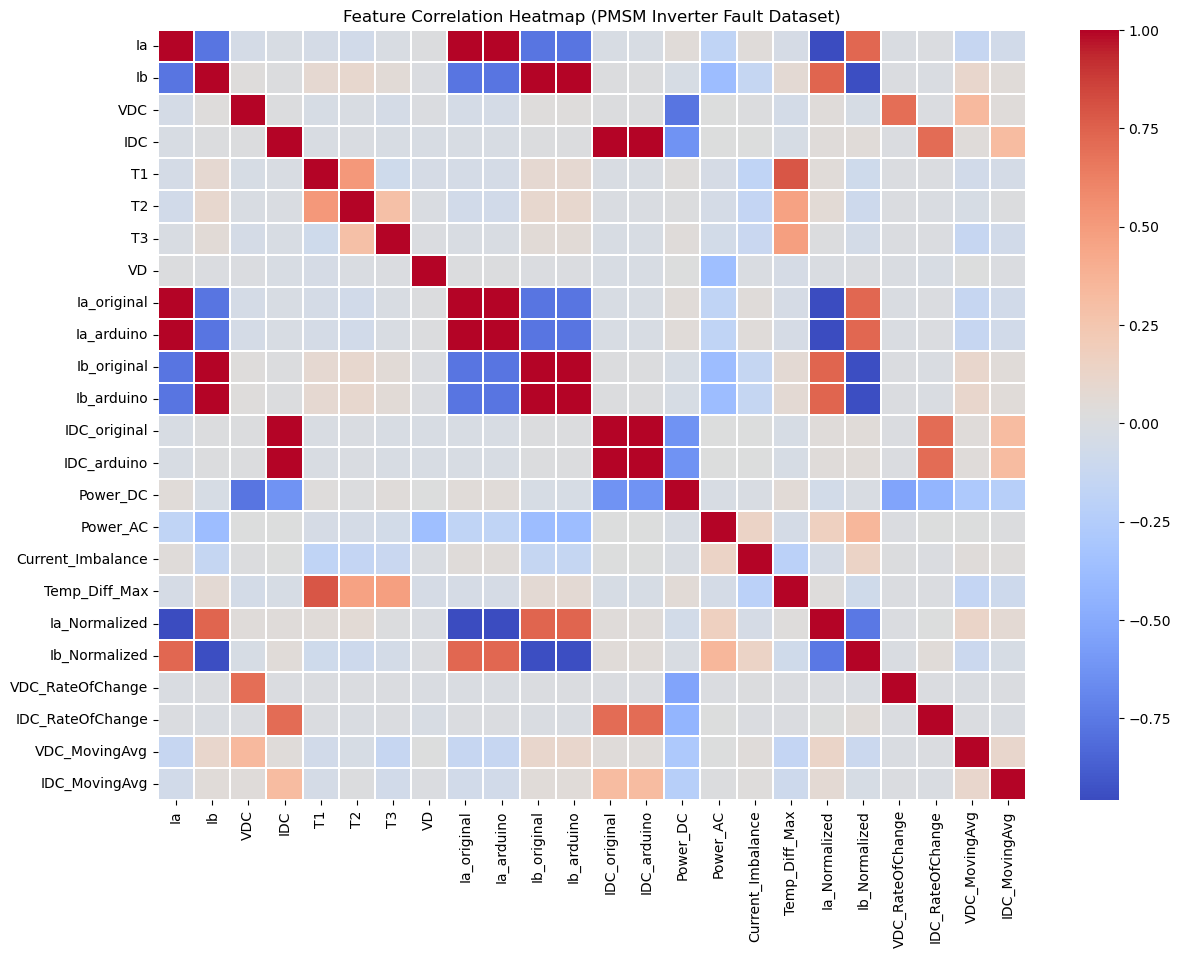

Features shape: (10848, 24)
Labels shape: (10848,)
Classes: ['F0', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8']
       Ia     Ib        VDC    IDC         T1         T2         T3  \
9   532.0  390.0 -17.106549  505.0  10.659462  11.401305  12.313061   
10  533.0  389.0 -17.106549  506.0  10.659462  11.566642  12.229922   
11  532.0  391.0 -17.106549  506.0  10.659462  11.483951  12.229922   
12  533.0  389.0 -26.881720  496.0  10.659462  11.815002  12.313061   
13  532.0  386.0 -17.106549  508.0  10.741722  11.401305  12.229922   

           VD FDD  Timestamp  ...   Power_DC    Power_AC  Current_Imbalance  \
9   -7.331378  F0        0.9  ...   8.861193   55.337243          -2.784314   
10 -12.218964  F0        1.0  ...   7.595308   92.228739          -2.823529   
11 -17.106549  F0        1.1  ...   7.595308  127.854350          -2.792079   
12  -2.443793  F0        1.2  ...  31.827957   18.445748          -2.823529   
13 -12.218964  F0        1.3  ...   5.063539   95.845552       

In [2]:
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, log_loss
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

zip_path = "PMSM-inverter-fault-diagnosis-3.0.zip"
extract_dir = "PMSM_inverter_fault_data"

# Extract once
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Check structure
os.listdir(extract_dir)

csv_path = "PMSM_inverter_fault_data/PMSM-inverter-fault-diagnosis-3.0/processed_data/converted_dataset.csv"
df = pd.read_csv(csv_path)
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()


# Labels
y = df['FDD'].values   # fault class (F0..F8)

# Features (drop label + timestamp if not needed)
X = df.drop(columns=['FDD', 'Timestamp']).values

FeatureCorrelation = df.drop(columns=['FDD', 'Timestamp'])
corr = FeatureCorrelation.corr()
plt.figure(figsize=(14,10))
sns.heatmap(corr, cmap="coolwarm", annot=False, linewidths=0.3)
plt.title("Feature Correlation Heatmap (PMSM Inverter Fault Dataset)")
plt.show()

print("Features shape:", X.shape)
print("Labels shape:", y.shape)
print("Classes:", sorted(set(y)))
print(df.head())
print("Number of features:", X.shape[1])
print("Feature names:", df.drop(columns=['FDD','Timestamp']).columns.tolist())


Löytyneet luokat: ['F0' 'F1' 'F2' 'F3' 'F4' 'F5' 'F6' 'F7' 'F8']
Koulutusdata: (8673, 24), Testidata: (2175, 24)
Koulutetaan Random Forest -mallia...
Tehdään ennustuksia...

== Classification Report ==
              precision    recall  f1-score   support

          F0       0.99      0.98      0.99       854
          F1       0.93      0.90      0.92       139
          F2       0.93      0.98      0.95       225
          F3       0.99      0.96      0.98        82
          F4       0.96      0.97      0.96        69
          F5       0.99      1.00      0.99        83
          F6       1.00      1.00      1.00       171
          F7       1.00      1.00      1.00       345
          F8       1.00      1.00      1.00       207

    accuracy                           0.98      2175
   macro avg       0.98      0.98      0.98      2175
weighted avg       0.98      0.98      0.98      2175



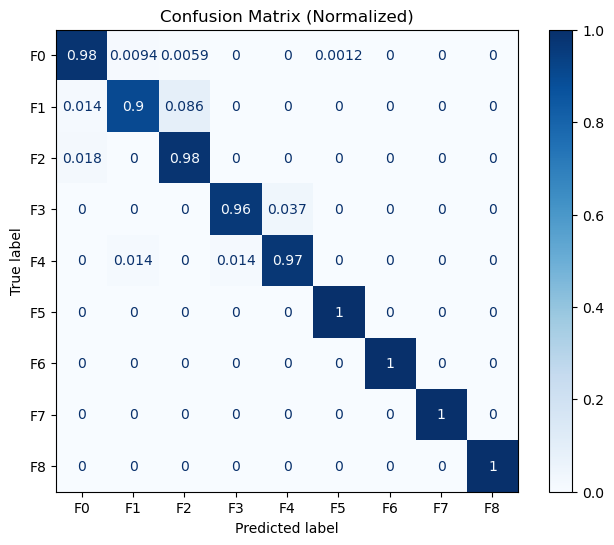


== Top 10 Tärkeintä Piirrettä ==
T1: 0.1986
Temp_Diff_Max: 0.1964
T3: 0.1851
T2: 0.1755
Ib_arduino: 0.0314
Ib_original: 0.0314
Ib: 0.0271
Current_Imbalance: 0.0263
Ib_Normalized: 0.0208
Ia: 0.0181


In [8]:
train_dfs = []
test_dfs = []

unique_faults = df['FDD'].unique()
print(f"Löytyneet luokat: {unique_faults}")

for fault in unique_faults:
    # 1. Eristä kyseinen vikatyyppi
    fault_data = df[df['FDD'] == fault]
    
    # 2. Järjestä aikaleiman mukaan (varmistaa aikajatkumon)
    fault_data = fault_data.sort_values('Timestamp')
    
    # 3. Jaa: Ensimmäiset 80% koulutukseen, viimeiset 20% testiin
    # shuffle=False on KRIITTINEN, jotta aikajärjestys säilyy
    tr, te = train_test_split(fault_data, test_size=0.2, shuffle=False)
    
    train_dfs.append(tr)
    test_dfs.append(te)

# Yhdistetään palaset takaisin isoiksi datasetiksi
train_df = pd.concat(train_dfs)
test_df = pd.concat(test_dfs)

# --- 3. Piirteiden ja maalin erottelu ---
# Poistetaan Timestamp (ettei malli opi "aika = vika") ja FDD (koska se on ennustettava asia)
drop_cols = ['FDD', 'Timestamp']

X_train = train_df.drop(columns=drop_cols).values
y_train_raw = train_df['FDD'].values

X_test = test_df.drop(columns=drop_cols).values
y_test_raw = test_df['FDD'].values

# Enkoodataan luokat numeroiksi (F0 -> 0, F1 -> 1 jne.)
le = LabelEncoder()
y_train = le.fit_transform(y_train_raw)
y_test = le.transform(y_test_raw)

# Sekoitetaan koulutusdata (vain sisäisesti), jotta malli ei näe luokkia järjestyksessä
X_train, y_train = shuffle(X_train, y_train, random_state=42)

print(f"Koulutusdata: {X_train.shape}, Testidata: {X_test.shape}")

# --- 4. Mallin koulutus (Random Forest) ---
print("Koulutetaan Random Forest -mallia...")
rf = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=42,
    class_weight="balanced" # Auttaa jos luokat ovat epätasapainossa
)
rf.fit(X_train, y_train)

# --- 5. Ennustus ja Evaluointi ---
print("Tehdään ennustuksia...")
y_pred = rf.predict(X_test)

# Tulostetaan raportti
print("\n== Classification Report ==")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Piirretään Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_pred, 
    display_labels=le.classes_, 
    normalize='true', # Näyttää prosentit riveittäin
    cmap='Blues',
    ax=ax
)
ax.set_title("Confusion Matrix (Normalized)")
plt.show()

# --- 6. Näytä tärkeimmät piirteet (Feature Importance) ---
feature_names = df.drop(columns=drop_cols).columns
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1][:10] # Top 10

print("\n== Top 10 Tärkeintä Piirrettä ==")
for i in indices:
    print(f"{feature_names[i]}: {importances[i]:.4f}")